In [1]:
import os
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import sklearn
import h5py
from tensorflow.keras import backend as K
from scipy.io import loadmat
from multiprocessing import Process, Lock, Manager
from PIL import Image

In [2]:
data_dir = "/DATA/phan92/tbi_diagnosis/data/raw/cardiac_displacement_3_updated_Oct13"

In [3]:
IPH_patients = ['DoD008', 'DoD009', 'DoD010', 'DoD012', 'DoD022', 'DoD047', 'DoD053', 
                'DoD062', 'DoD066', 'DoD067', 'DoD069', 'DoD074', 'DoD075', 'DoD078', 
                'DoD085', 'DoD089', 'DoD093', 'DoD101', 'DoD105', 'DoD107', 'DoD110', 
                'DoD112', 'DoD113', 'DoD120', 'DoD121', 'DoD126', 'DoD129', 'DoD130', 
                'DoD133']

old_bad_patients = [1, 14, 22, 23, 27, 28, 32, 34, 35, 36, 37, 38, 39, 44, 49, 69, 71, 
                78, 82, 90, 98, 101, 121, 124, 128, 133, 928]

bad_patients = ['DoD027', 'DoD028', 'DoD035', 'DoD036', 'DoD038', 'DoD049', 'DoD069', 'DoD090']

In [ ]:
# find out all different size of the dataset
data_sizes = []
for patient in os.listdir(data_dir):
    for scan in os.listdir(os.path.join(data_dir, patient)):
        data = loadmat(os.path.join(data_dir, patient, scan))
        size_of_displacement = data['displacement'].shape
        print(scan, size_of_displacement)
        if size_of_displacement not in data_sizes:
            data_sizes.append(size_of_displacement)

In [ ]:
len(data_sizes)

In [ ]:
data_sizes

In [4]:
# Extract axis information to produce cone-shape images
def extract_axis(datapath, axisPath):
    data = loadmat(datapath)

    xaxis = np.array(list(data['xAxis']))
    yaxis = np.array(list(data['zAxis']))

    xaxis = cv2.resize(xaxis, (80, 256), interpolation=cv2.INTER_AREA)
    yaxis = cv2.resize(yaxis, (80, 256), interpolation=cv2.INTER_AREA)

    xaxis += 100
    yaxis -= 4

    print("saved axis info in : {}".format(axisPath))
    np.save(os.path.join(axisPath, "xAxis.npy"), xaxis)
    np.save(os.path.join(axisPath, "yAxis.npy"), yaxis)
    
    return xaxis, yaxis

In [5]:
# extract generic axis information
axisPath = "/DATA/phan92/notebooks"
rand_input_file = "/DATA/phan92/test_resource/raw_data/DoD110/DoD110_Ter002_LO1_Displacement_Normalized_3.mat"
xAxis, yAxis = extract_axis(rand_input_file, axisPath)

saved axis info in : /DATA/phan92/notebooks


In [ ]:
# extract specific axis information of a patient
axisPath = "/DATA/phan92/notebooks"
input_file = "/DATA/phan92/tbi_diagnosis/data/raw/cardiac_displacement_3_updated_Oct13/DoD042/DoD042_Ter015_LO5_Displacement_Normalized_3.mat"
xAxis, yAxis = extract_axis(input_file, axisPath)

In [ ]:
def display_input(label, bMode, displacement, xAxis, yAxis):
    """
    Display an input
    
    Args:
        label (numpy.arr): the label
        bMode (numpy.arr): bMode
        displacement (numpy.arr): displacement
        xAxis (numpy.arr): numpy array contain x axis for display the cone
        yAxis (numpy.arr): numpy array contain y axis for display the cone
    """
    label.reshape([256, 80])
    bMode.reshape([256, 80])
    _, bin_edges = np.histogram(bMode, bins=25)
    displacement.reshape([256, 80])
    # display
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    fig.patch.set_facecolor('white')

    ax[2].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma', vmin=0, vmax=2)
    ax[2].set_title("Mask", fontsize = 18, fontweight ="bold")
    ax[2].axis('off')
    
    ax[0].pcolormesh(xAxis, -yAxis, bMode, shading='auto', cmap='binary', vmin=bin_edges[2], vmax=bin_edges[-2])
    ax[0].set_title("B-Mode", fontsize = 18, fontweight ="bold")
    ax[0].axis('off')
    
    ax[1].pcolormesh(xAxis, -yAxis, displacement, shading='auto')
    ax[1].set_title("Displacement", fontsize = 18, fontweight ="bold")
    ax[1].axis('off')
    
    plt.show()

In [6]:
def standardize(displacement, x_dim, y_dim):
    """
    Standardize displacement data
    Output values have a mean of 0 and std = 1

    Args:
        displacement (numpy array): one displacement frame
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
    Return:
        displace_data (numpy array): normalized displacement shape (x_dim, y_dim)
    """
    displacement = cv2.resize(displacement, (y_dim, x_dim))
    
    # center around 0
    centered = displacement - displacement.mean()
    
    # divide by the standard deviation
    if np.std(centered) != 0:
        centered_scaled = centered / np.std(centered)
        
    displacement = centered_scaled
 
    return displacement

In [7]:
def extract_single_frame_from_raw_displacement(rawData, cardiac_cycle=1, frame=0):
    """
    Extract the displacement data from a patient file
    Choose one cardiac cycle and a single frame in this cardiac cycle
    
    Args:
        rawData (raw from .mat): raw data loaded from .mat file
        cardiac_cycle (int): number of the th cycle to extract data from
        frame (int): the th frame after the start of a cardiac cycle 
        
    Returns:
        displace_data (numpy array): displacement data (x_dim, y_dim, 1)
    """
    displacement = np.array(list(rawData['displacement']))
    hrTimes = np.array(list(rawData['hrTimes']))
    disShape = displacement.shape
    # extract data from the cardiac_cycle th cycle
    start = int(math.ceil(30 * hrTimes[0, cardiac_cycle]))
    displace_data = np.zeros([disShape[0], disShape[1], 1])
    # take the th displacement after the start of a cardiac cycle
    displace_data[:,:,0] = displacement[:, :, start + frame]
    
    return np.array(displace_data.astype('float64'))

In [8]:
def extract_single_frame_from_displacementNorm(rawData, cardiac_cycle=0, frame=9):
    """
    Extract the displacement data from displacementNorm dataset
    Choose one cardiac cycle and a single frame in this cardiac cycle
    displacementNorm has shape (x_dim, y_dim, 30, n_cycles)
    
    Args:
        rawData (raw from .mat): raw data loaded from .mat file
        cardiac_cycle (int): number of the th cycle to extract data from
        frame (int): the th frame after the start of a cardiac cycle 
        
    Returns:
        displace_data (numpy array): displacement data (x_dim, y_dim)
    """
    displacement = np.array(list(rawData['displacementNorm']))
    disShape = displacement.shape
    # extract data from the cardiac_cycle th cycle
    displace_data = np.zeros([disShape[0],disShape[1]])
    if (len(disShape) == 4):
        displace_data[:,:] = displacement[:, :, frame, cardiac_cycle]
    else:
        # handle cases where there is only one cycle
        displace_data[:,:] = displacement[:, :, frame]
                    
    return np.array(displace_data.astype('float64'))

In [9]:
def make_label(rawData, x_dim, y_dim, objective):
    """
    Make the label according to model's objective
    Objective = 0: find skull
    Objective = 1: find bleed
    Objective = 2: find brain
    Objective = 3: find ventricle
    
    Args:
        rarData: data read from loadmat()
        objective (int): find brain or fine bleed
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
    
    Return:
        label (numpy.arr): the label (x_dim, y_dim)
    """
    # get label
    if objective == 0:
        # skull
        mask = np.array(list(rawData['skullMaskThick']))
    elif objective == 1:
        # bleed
        mask = np.array(list(rawData['bloodMaskThick']))
    elif objective == 2:
        mask = np.array(list(rawData['brainMask']))
    else:
        mask = np.array(list(rawData['ventMaskThick']))
    
    # resize the masks
    label = cv2.resize(mask, (y_dim, x_dim))
    
    return label.astype('float32')

In [10]:
def get_bMode(rawData, x_dim, y_dim):
    """
    Get the bMode image from raw data
    
    Args:
        rarData: data read from loadmat()
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
        
    Returns:
        bMode (numpy.arr): bMode image (x_dim, y_dim)
    """
    # get the bmode from raw data
    bMode = np.array(list(rawData['bModeNorm']))
    
    # resize
    bMode = np.log10(bMode)
    bMode = bMode.astype('float64')
    
    # some bModeNorm data have dimensions (x_dim, y_dim)
    # those do not need to be processed in the if statement
    if len(bMode.shape) > 2:
        bMode = np.mean(bMode, axis=2)
        bMode = bMode[:, :, 0]
    bMode = cv2.resize(bMode, (y_dim, x_dim))
    
    return bMode

In [ ]:
def process_one_patient(path, x_dim, y_dim, objective):
    """
    Process the raw data for a patient
    
    Args:
        path (str): path to the data file
        objective (int): the objective of processing (0 to find skull, 1 to find bleed)
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
        
    Returns:
        displacement_list: displacement frames from a mat file (N, x_dim, y_dim, 1)
        label_list: labels (N, x_dim, y_dim, 1)
        bMode_list: corresponding bMode images (N, x_dim, y_dim, 1)
        fileNames: names of files where data come from (N,)
    """
    # list of displacement
    displacement_list = []
    # list of bMode
    bMode_list = []
    #list of labels
    label_list = []
    # list of file names
    fileNames = []
    # process all file in the directory
    for file in os.listdir(path):
        if ".mat" in file:
            filePath = os.path.join(path, file)
            rawData = loadmat(filePath)
            
            # extract the displacement data
            #displace_data = extract_single_frame_from_raw_displacement(rawData)
            displace_data = extract_single_frame_from_displacementNorm(rawData)
            # standardize
            displace_data = standardize(displace_data, x_dim, y_dim)
            displace_data = displace_data.reshape([x_dim, y_dim, 1])
            
            """
            if objective == 1:
                # delete non-brain from input
                brainMask = np.array(list(rawData['brainMask']))
                brainMask = cv2.resize(brainMask, (80, 256))
                displace_data[:,:, 0] = np.where(brainMask == 0, 0.0, displace_data[:,:,0])
            """

            # get bMode images
            bMode = get_bMode(rawData, x_dim, y_dim)
            
            # make label
            label = make_label(rawData, x_dim, y_dim, objective)

            displacement_list.append(displace_data)
            label_list.append(label)
            bMode_list.append(bMode)
            fileNames.append(file)
            
    return (np.array(displacement_list), 
            np.array(label_list), 
            np.array(bMode_list), 
            np.array(fileNames))

In [ ]:
def process_all_patients(path, objective=1, x_dim=256, y_dim=80, patient_nums=None):
    """
    Process data of all patients

    Args:
        path (string): path to folder storing patient data
        objective (integer): 0-skull mask, 1-blood mask
        patient_nums (list(string)): list of patient numbers to process;
                                process all if None is given;
                                format: DoDxxx
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
    Return:
        numpy array of displacement data, label, bMode, list of patient files
    """
    displacement_list = []
    label_list = []
    bMode_list = []
    file_list = []
    
    # process all if no patient number is given
    if patient_nums is None:
        patient_nums = [patient for patient in os.listdir(path) if patient not in bad_patients]
    
    for patient_num in patient_nums:
        if os.path.isdir(os.path.join(path, patient_num)):
            print("Process data for patient", patient_num)
            dataPath = os.path.join(path, patient_num)
            displacement, label, bMode, fileNames = process_one_patient(path=dataPath, 
                                                                   x_dim=x_dim, 
                                                                   y_dim=y_dim, 
                                                                   objective=objective)
            displacement_list.extend(displacement)
            label_list.extend(label)
            bMode_list.extend(bMode)
            file_list.extend(fileNames)
        else:
            print('Patient' + patient_num + 'does not exist')
    
    print("Processed", len(patient_nums), "patients")
    
    return np.array(displacement_list), np.array(label_list), np.array(bMode_list), np.array(file_list)

In [ ]:
def multiprocess_all_patients(path, objective=1, x_dim=256, y_dim=80, patient_nums=None):
    """
    Process all the patient in parallel using 10 processes
    """ 
    manager = Manager()
    
    displacement_list = manager.list()
    label_list = manager.list()
    bMode_list = manager.list()
    file_list = manager.list()
    
    # inner function for multiprocessing
    def process_patient(lock, path, patient, x_dim, y_dim, objective):
        lock.acquire()
        print("Process data for patient", patient)
        lock.release()
        dataPath = os.path.join(path, patient)
        displacement, label, bMode, fileNames = process_one_patient(path=dataPath, 
                                                                       x_dim=x_dim, 
                                                                       y_dim=y_dim, 
                                                                       objective=objective)

        # lock the share resource and add data to common storage
        lock.acquire()
        displacement_list.extend(displacement)
        label_list.extend(label)
        bMode_list.extend(bMode)
        file_list.extend(fileNames)
        lock.release()
        # end of inner function
    
    # process all if no patient number is given
    if patient_nums is None:
        patient_nums = [patient for patient in os.listdir(path) if patient not in bad_patients]
    
    # total # of patient
    num_patients = len(patient_nums)
    # current index in the list of patients
    curr_idx = 0;
    # number of threads spawned so far
    thread_num = 0
    # max num of threads
    max_num_threads = 5
    
    lock = Lock()
    while curr_idx < num_patients:
        processes = []
        while thread_num < max_num_threads and curr_idx < num_patients:
            p = Process(target=process_patient, args=(lock, 
                                                      path, 
                                                      patient_nums[curr_idx], 
                                                      x_dim, 
                                                      y_dim, 
                                                      objective))
            p.start()
            processes.append(p)
            curr_idx += 1
            thread_num += 1
        
        # reset the number of threads
        thread_num = 0
        # terminate the processes
        for process in processes:
            process.join()
    print("Processed", len(patient_nums), "patients")
    
    return np.array(displacement_list), np.array(label_list), np.array(bMode_list), np.array(file_list)

In [ ]:
# get data from file
displacement, label, bMode, fileList = process_all_patients(data_dir, 
                                                          objective=3, 
                                                          x_dim=256, 
                                                          y_dim=80, 
                                                          patient_nums=['DoD009'])

In [ ]:
displacement.shape

In [ ]:
label.shape

In [ ]:
label = one_hot(label, 3)

In [ ]:
label.shape

In [ ]:
bMode.shape

In [ ]:
plt.pcolormesh(xAxis, -yAxis, np.squeeze(displacement[0,:,:,:], axis=-1), shading='flat')

In [ ]:
plt.pcolormesh(xAxis, -yAxis, np.squeeze(displacement[0,:,:,:], axis=-1), shading='flat')

In [ ]:
display_input(label[20,:,:], bMode[20,:,:], displacement[20,:,:,0], xAxis, yAxis)

In [ ]:
# get data from file
displacement, label, bMode, fileList = multiprocess_all_patients(data_dir, 
                                                          objective=1, 
                                                          x_dim=256, 
                                                          y_dim=80, 
                                                          patient_nums=['DoD009', 'DoD053', 'DoD089', 'DoD012', 'DoD102'])

In [ ]:
fileList.shape

In [ ]:
def one_hot(label, num_classes=3):
    """
    Create one hot label from the provided label
    
    Args:
        label: label of shape (N, x_dim, y_dim)
        num_classes (int): number of classes to resolve
        
    Returns:
        label: onehot label (N, x_dim, y_dim, n_channels)
    """
    if num_classes == 2:
        # create label to find brain tissue
        # if the probability of brain is >= 0.5
        # set the label to 1, 0 otherwise
        label = np.where(label >= 0.5, 1, 0)
    else:
        # create label to find bleed
        # if the probability of bleed is >= 0.3
        # set the label to 1
        label = np.where(label >= 1.3, 1, 0)

    label = np.expand_dims(label, axis=-1)
    
    return label

In [ ]:
def make_hdf5(file_name, save_path, data_path):
    """
    Make hdf5 data file
    Pool all patient files before dividing into dev set and
    
    Args"
        file_name: name of hdf5
        save_path: path to saved file
        data_path: path to raw data
    """
    # process data
    displacement, label, bMode, fileNames = process_all_patients(data_path, objective=1, patient_nums=None)
    
    # change the dimensions of displacement
    # from (N, x_dim, y_dim, n_channel)
    # to (N, n_channel, x_dim, y_dim)
    #displacement = np.moveaxis(displacement, 3, 1)
    
    # remove the n_channel from label and bMode
    # from (N, x_dim, y_dim, n_channel = 1)
    # to (N, x_dim, y_dim)
    #label = np.squeeze(label, axis=3)
    #bMode = np.squeeze(bMode, axis=3)
    
    # create a hdf5 file
    f = h5py.File(os.path.join(save_path, file_name), 'w')
    
    training_group = f.create_group("training")
    testing_group = f.create_group('testing')
    
    # shuffle the dataset
    displacement, label, bMode, fileNames = sklearn.utils.shuffle(displacement, 
                                                                  label, 
                                                                  bMode, 
                                                                  fileNames, 
                                                                  random_state=0)
    
    num_examples = displacement.shape[0]
    # add data to the defined data buckets
    _add_dataset(training_group, 
                 displacement[0: int(0.8*num_examples)],
                 label[0: int(0.8*num_examples)],
                 bMode[0: int(0.8*num_examples)],
                 fileNames[0: int(0.8*num_examples)])
    _add_dataset(testing_group, 
                 displacement[int(0.8*num_examples):], 
                 label[int(0.8*num_examples):],
                 bMode[int(0.8*num_examples):],
                 fileNames[int(0.8*num_examples):])
    
    f.close()

In [ ]:
def make_hdf5_by_patient_group_parallel(file_name, save_path, data_path, objective):
    """
    Make hdf5 data file
    Divide patients into dev set and test set before process
    
    Args"
        file_name: name of hdf5
        save_path: path to saved file
        data_path: path to raw data
    """
    # divide patient into dev set and test set
    all_patients = [patient for patient in os.listdir(data_path) if patient not in bad_patients]
    all_patients = sklearn.utils.shuffle(all_patients, random_state=0)
    dev_patients = all_patients[0: int(0.9*len(all_patients))]
    test_patients = all_patients[int(0.9*len(all_patients)):]
                                       
    # process data
    print("Processing dev patients")
    dev_displacement, dev_label, dev_bMode, dev_fileNames = multiprocess_all_patients(data_path, 
                                                                                 objective=objective, 
                                                                                 patient_nums=dev_patients)
    
    print("Processing test patients")
    test_displacement, test_label, test_bMode, test_fileNames = multiprocess_all_patients(data_path, 
                                                                                 objective=objective, 
                                                                                 patient_nums=test_patients)
    
    # create a hdf5 file
    f = h5py.File(os.path.join(save_path, file_name), 'w')
    
    dev_group = f.create_group('dev')
    test_group = f.create_group('test')
    
    # add data to the defined data buckets
    _add_dataset(dev_group, 
                 dev_displacement,
                 dev_label,
                 dev_bMode,
                 dev_fileNames)
    _add_dataset(test_group, 
                 test_displacement, 
                 test_label,
                 test_bMode,
                 test_fileNames)
    
    f.close()

In [ ]:
def make_hdf5_by_patient_group(file_name, save_path, data_path, objective):
    """
    Make hdf5 data file
    Divide patients into dev set and test set before process
    
    Args"
        file_name: name of hdf5
        save_path: path to saved file
        data_path: path to raw data
    """
    # divide patient into dev set and test set
    all_patients = [patient for patient in os.listdir(data_path) if patient not in bad_patients]
    all_patients = sklearn.utils.shuffle(all_patients, random_state=0)
    dev_patients = all_patients[0: int(0.9*len(all_patients))]
    test_patients = all_patients[int(0.9*len(all_patients)):]
                                       
    # process data
    print("Processing dev patients")
    dev_displacement, dev_label, dev_bMode, dev_fileNames = process_all_patients(data_path, 
                                                                                 objective=objective, 
                                                                                 patient_nums=dev_patients)
    
    print("Processing test patients")
    test_displacement, test_label, test_bMode, test_fileNames = process_all_patients(data_path, 
                                                                                 objective=objective, 
                                                                                 patient_nums=test_patients)
    
    # create a hdf5 file
    f = h5py.File(os.path.join(save_path, file_name), 'w')
    
    dev_group = f.create_group('dev')
    test_group = f.create_group('test')
    
    # add data to the defined data buckets
    _add_dataset(dev_group, 
                 dev_displacement,
                 dev_label,
                 dev_bMode,
                 dev_fileNames)
    _add_dataset(test_group, 
                 test_displacement, 
                 test_label,
                 test_bMode,
                 test_fileNames)
    
    f.close()

In [ ]:
def _add_dataset(group: h5py.Group, displacement, label, bMode, fileNames):
    """
    Add a dataset to h5py group
    The saved data have shapes:
        x (N, nchannel, 256, 80)
        y (N, n_class, 256, 80)
        bMode (N, 256, 80)
        names (N, 1)
    
    @param: group: h5py group
    @param: displacement: displacement data (N, n_channel, x_dim, y_dim)
    @param: label: label (N, n_class, x_dim, y_dim)
    @param: bMode: bMode ultrasound (N, x_dim, y_dim)
    @param: fileNames: file names of the displacement data (N,)
    """
    # convert the label to a ASCII format for h5py
    asciiList = [name.encode("ascii", "ignore") for name in fileNames]
    
    x = group.create_dataset('x', data=displacement)
    y = group.create_dataset('y', data=label)
    bMode = group.create_dataset('bMode', data=bMode)
    filename = group.create_dataset('filename', data=asciiList)

In [ ]:
import time

start = time.time()
make_hdf5_by_patient_group_parallel('test3_displacementNorm_data.hdf5', 
                           '/DATA/phan92/tbi_diagnosis/data/processed', 
                           data_dir,
                           1)
end = time.time()
print((end - start)/60)

In [ ]:
start = time.time()
make_hdf5_by_patient_group('test2_displacementNorm_data.hdf5', 
                           '/DATA/phan92/tbi_diagnosis/data/processed', 
                           data_dir,
                           1)
end = time.time()
print((end - start)/60)

In [ ]:
make_hdf5_by_patient_group('bleed_displacementNorm_data.hdf5', 
                           '/DATA/phan92/tbi_diagnosis/data/processed', 
                           data_dir,
                           1)

In [ ]:
dataset = h5py.File('/DATA/phan92/tbi_diagnosis/data/processed/bleed_displacementNorm_data.hdf5', 'r')

In [ ]:
dev = dataset['dev']

In [ ]:
x = dev['x']
y = dev['y']
bMode = dev['bMode']

In [ ]:
idx = 310

In [ ]:
display_input(y[idx,:,:], bMode[idx,:,:], x[idx,:,:,0], xAxis, yAxis)

In [ ]:
test = dataset['test']

In [ ]:
x_test = test['x']

In [ ]:
x_test

In [ ]:
dataset.close()

In [ ]:
def convert_displacement_to_image(np_array, save_path):
    """
    Convert a numpy array to an image
    
    Args:
        np_array (numpy array): an numpy array (height, width, 1)
        save_path (string): absolute path to the save file
    """
    image = np.squeeze(np_array, axis=-1)
    plt.imsave(save_path, image)

In [ ]:
def convert_label_to_image(label, save_path):
    """
    Convert a label in the form of numpy array to an image
    
    Args:
        label (numpy array): an numpy array (height, width)
        save_path (string): absolute path to the save file
    """
    plt.imsave(save_path, image, cmap=plt.cm.gray)

In [ ]:
image = x[9]

In [ ]:
image.shape

In [ ]:
convert_displacement_to_image(image,'/DATA/phan92/tbi_diagnosis/notebooks/image.jpg')

In [ ]:
img = Image.open('/DATA/phan92/tbi_diagnosis/notebooks/image.jpg')

In [ ]:
img

In [ ]:
img = img.getdata()

In [ ]:
arr = np.array(img)

In [ ]:
arr.shape

In [ ]:
image = x[9]

In [ ]:
image.shape

In [ ]:
arr = np.squeeze(image, axis=-1)

In [ ]:
arr.shape

In [ ]:
arr = np.float32(arr)

In [ ]:
im_rbg = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)

In [ ]:
im_rbg

In [ ]:
im_rbg.shape

In [ ]:
plt.imshow(im_rbg)

In [ ]:
converted_image = Image.fromarray(im_rbg)

In [ ]:
cv2.imwrite('/DATA/phan92/tbi_diagnosis/notebooks/image_rbg.jpg', im_rbg)

In [ ]:
img = Image.open('/DATA/phan92/tbi_diagnosis/notebooks/image_rbg.jpg')

In [ ]:
img

In [ ]:
img = np.array(img)

In [ ]:
img.shape

In [ ]:
def get_image(file, image_size_wight, image_size_height,gray=False):
    # load image
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    if gray==True:
        img = img.convert('L')
    # center crop
    img_center_crop = img
    # resize
    img_resized = img_center_crop.resize((image_size_height, image_size_wight), Image.ANTIALIAS)
    edge = cv2.Canny(np.asarray(np.uint8(img_resized)),10,1000)
    
    flag = False
    # convert to numpy and normalize
    img_array = np.asarray(img_resized).astype(np.float32)/255.0
    edge = np.asarray(edge).astype(np.float32)/255.0
    #print(img_array)
    if gray==True:
        img_array=(img_array >=0.5).astype(int)
    img.close()
    return img_array,edge

In [ ]:
img_resized = cv2.resize(im_rbg, (256, 256))
edge = cv2.Canny(np.asarray(np.uint8(img_resized)),10,1000)

In [ ]:
plt.imshow(img_resized)

In [ ]:
plt.imshow(edge)

In [ ]:
label = y[2]

In [ ]:
label = Image.fromarray(label)

In [ ]:
label_resized = cv2.resize(label(256, 256))

# Process data for cascade network

In [11]:
def make_hdf5_by_patient_group(file_name, save_path, data_path, objective):
    """
    Make hdf5 data file
    Divide patients into dev set and test set before process
    
    Args"
        file_name: name of hdf5
        save_path: path to saved file
        data_path: path to raw data
    """
    # divide patient into dev set and test set
    all_patients = [patient for patient in os.listdir(data_path) if patient not in bad_patients]
    all_patients = sklearn.utils.shuffle(all_patients, random_state=0)
    dev_patients = all_patients[0: int(0.9*len(all_patients))]
    test_patients = all_patients[int(0.9*len(all_patients)):]
                                       
    # process data
    print("Processing dev patients")
    dev_displacement, dev_label, dev_ROI, dev_bMode, dev_fileNames = process_all_patients(data_path, 
                                                                                 objective=objective, 
                                                                                 patient_nums=dev_patients)
    
    print("Processing test patients")
    test_displacement, test_label, test_ROI, test_bMode, test_fileNames = process_all_patients(data_path, 
                                                                                 objective=objective, 
                                                                                 patient_nums=test_patients)
    
    # create a hdf5 file
    f = h5py.File(os.path.join(save_path, file_name), 'w')
    
    dev_group = f.create_group('dev')
    test_group = f.create_group('test')
    
    # add data to the defined data buckets
    _add_dataset(dev_group, 
                 dev_displacement,
                 dev_label,
                 dev_ROI,
                 dev_bMode,
                 dev_fileNames)
    _add_dataset(test_group, 
                 test_displacement, 
                 test_label,
                 test_ROI,
                 test_bMode,
                 test_fileNames)
    
    f.close()

In [12]:
def _add_dataset(group: h5py.Group, displacement, label, ROI, bMode, fileNames):
    """
    Add a dataset to h5py group
    The saved data have shapes:
        x (N, nchannel, 256, 80)
        y (N, n_class, 256, 80)
        bMode (N, 256, 80)
        names (N, 1)
    
    @param: group: h5py group
    @param: displacement: displacement data (N, n_channel, x_dim, y_dim)
    @param: label: label (N, n_class, x_dim, y_dim)
    @param: bMode: bMode ultrasound (N, x_dim, y_dim)
    @param: fileNames: file names of the displacement data (N,)
    """
    # convert the label to a ASCII format for h5py
    asciiList = [name.encode("ascii", "ignore") for name in fileNames]
    
    x = group.create_dataset('x', data=displacement)
    y = group.create_dataset('y', data=label)
    ROI = group.create_dataset('ROI', data=ROI)
    bMode = group.create_dataset('bMode', data=bMode)
    filename = group.create_dataset('filename', data=asciiList)

In [13]:
def process_one_patient(path, x_dim, y_dim, objective):
    """
    Process the raw data for a patient
    
    Args:
        path (str): path to the data file
        objective (int): the objective of processing (0 to find skull, 1 to find bleed)
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
        
    Returns:
        displacement_list: displacement frames from a mat file (N, x_dim, y_dim, 1)
        label_list: labels (N, x_dim, y_dim, 1)
        bMode_list: corresponding bMode images (N, x_dim, y_dim, 1)
        fileNames: names of files where data come from (N,)
    """
    # list of displacement
    displacement_list = []
    # list of bMode
    bMode_list = []
    # list of ROI
    ROI_list =[]
    #list of labels
    label_list = []
    # list of file names
    fileNames = []
    # process all file in the directory
    for file in os.listdir(path):
        if ".mat" in file:
            filePath = os.path.join(path, file)
            rawData = loadmat(filePath)
            
            # extract the displacement data
            #displace_data = extract_single_frame_from_raw_displacement(rawData)
            displace_data = extract_single_frame_from_displacementNorm(rawData)
            # standardize
            displace_data = standardize(displace_data, x_dim, y_dim)
            displace_data = displace_data.reshape([x_dim, y_dim, 1])
            
            """"
            if objective == 1:
                # delete non-brain from input
                brainMask = np.array(list(rawData['brainMask']))
                brainMask = cv2.resize(brainMask, (80, 256))
                displace_data[:,:, 0] = np.where(brainMask == 0, 0.0, displace_data[:,:,0])
            """
            
            # get brain ROI
            ROI = make_label(rawData, x_dim, y_dim, objective=2)
            ROI = np.expand_dims(ROI, axis=-1)

            # get bMode images
            bMode = get_bMode(rawData, x_dim, y_dim)
            
            # make label
            label = make_label(rawData, x_dim, y_dim, objective)

            displacement_list.append(displace_data)
            label_list.append(label)
            ROI_list.append(ROI)
            bMode_list.append(bMode)
            fileNames.append(file)
            
    return (np.array(displacement_list), 
            np.array(label_list),
            np.array(ROI_list),
            np.array(bMode_list), 
            np.array(fileNames))

In [14]:
def process_all_patients(path, objective=1, x_dim=256, y_dim=80, patient_nums=None):
    """
    Process data of all patients

    Args:
        path (string): path to folder storing patient data
        objective (integer): 0-skull mask, 1-blood mask
        patient_nums (list(string)): list of patient numbers to process;
                                process all if None is given;
                                format: DoDxxx
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
    Return:
        numpy array of displacement data, label, bMode, list of patient files
    """
    displacement_list = []
    label_list = []
    ROI_list = []
    bMode_list = []
    file_list = []
    
    # process all if no patient number is given
    if patient_nums is None:
        patient_nums = [patient for patient in os.listdir(path) if patient not in bad_patients]
    
    for patient_num in patient_nums:
        if os.path.isdir(os.path.join(path, patient_num)):
            print("Process data for patient", patient_num)
            dataPath = os.path.join(path, patient_num)
            displacement, label, ROI, bMode, fileNames = process_one_patient(path=dataPath, 
                                                                   x_dim=x_dim, 
                                                                   y_dim=y_dim, 
                                                                   objective=objective)
            displacement_list.extend(displacement)
            label_list.extend(label)
            ROI_list.extend(ROI)
            bMode_list.extend(bMode)
            file_list.extend(fileNames)
        else:
            print('Patient' + patient_num + 'does not exist')
    
    print("Processed", len(patient_nums), "patients")
    
    return np.array(displacement_list), np.array(label_list), np.array(ROI_list), np.array(bMode_list), np.array(file_list)


In [ ]:
# get data from file
displacement, label, ROI, bMode, fileList = process_all_patients(data_dir, 
                                                          objective=3, 
                                                          x_dim=256, 
                                                          y_dim=80, 
                                                          patient_nums=['DoD009'])

In [ ]:
plt.pcolormesh(xAxis, -yAxis, np.squeeze(ROI[7,:,:,:], axis=-1), shading='flat')

In [15]:
make_hdf5_by_patient_group('vent_cascade_displacementNorm_data.hdf5', 
                           '/DATA/phan92/tbi_diagnosis/data/processed', 
                           data_dir,
                           3)

Processing dev patients
Process data for patient DoD060
Process data for patient DoD119
Process data for patient DoD007
Process data for patient DoD053
Process data for patient DoD089
Process data for patient DoD012
Process data for patient DoD102
Process data for patient DoD015
Process data for patient DoD125
Process data for patient DoD024
Process data for patient DoD050
Process data for patient DoD004
Process data for patient DoD063
Process data for patient DoD112
Process data for patient DoD084
Process data for patient DoD032
Process data for patient DoD001
Process data for patient DoD100
Process data for patient DoD106
Process data for patient DoD008
Process data for patient DoD131
Process data for patient DoD033
Process data for patient DoD098
Process data for patient DoD105
Process data for patient DoD005
Process data for patient DoD097
Process data for patient DoD116
Process data for patient DoD022
Process data for patient DoD132
Process data for patient DoD071
Process data for

In [16]:
dataset = h5py.File('/DATA/phan92/tbi_diagnosis/data/processed/vent_cascade_displacementNorm_data.hdf5', 'r')

In [18]:
test = dataset['dev']

In [19]:
ROI = test['ROI']

/tmp/ipykernel_22135/990591613.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xAxis, -yAxis, np.squeeze(ROI[7,:,:,:], axis=-1), shading='flat')


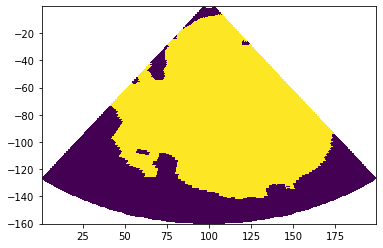

In [20]:
plt.pcolormesh(xAxis, -yAxis, np.squeeze(ROI[7,:,:,:], axis=-1), shading='flat')

In [21]:
x = test['x']

/tmp/ipykernel_22135/2974664319.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xAxis, -yAxis, np.squeeze(x[7,:,:,:], axis=-1), shading='flat')


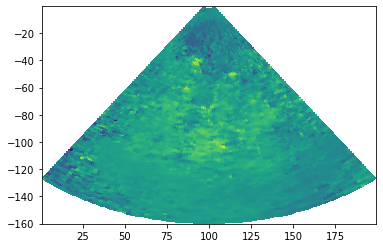

In [22]:
plt.pcolormesh(xAxis, -yAxis, np.squeeze(x[7,:,:,:], axis=-1), shading='flat')

In [ ]:
dataset.close()

# Descriptive statistics of the data

In [ ]:
rawDataPath = '/DATA/phan92/raw_data/cardiac_displacement_3_updated_Oct13'

In [ ]:
data = []
fileNames = []

In [ ]:
# collect the data
for patient in os.listdir(rawDataPath):
    print(patient)
    #patient_num = int(patient[3:])
    #print(patient_num)
    if patient not in bad_patients:
        patientPath = os.path.join(rawDataPath, patient)
        for scan in os.listdir(patientPath):
            scanPath = os.path.join(patientPath, scan)
            fileNames.append(scanPath)
            rawData = loadmat(scanPath)
            displacement = np.array(list(rawData['displacement']))
            hrTimes = np.array(list(rawData['hrTimes']))
            hrShape = hrTimes.shape
            disShape = displacement.shape
            for h in range(0, hrShape[1] - 1):
                start = int(math.ceil(30 * hrTimes[0, h]))
                # get 10 points after start of a cardiac cycle
                for i in range(0, 11):
                    data.append(displacement[:, :, start + i])

In [ ]:
data = np.array(data)

In [ ]:
data.shape

In [ ]:
# collect the data
for patient in os.listdir(rawDataPath):
    print(patient)
    patientPath = os.path.join(rawDataPath, patient)
    for scan in os.listdir(patientPath):
        scanPath = os.path.join(patientPath, scan)
        fileNames.append(scanPath)
        rawData = loadmat(scanPath)
        data.append(np.array(rawData['displacement']))

In [ ]:
average = []
maximum = []
minimum = []

In [ ]:
for sample in data:
    average.append(np.mean(sample))
    maximum.append(np.max(sample))
    minimum.append(np.min(sample))

In [ ]:
# max of maximum
np.max(maximum)

In [ ]:
# min of maximum
np.min(maximum)

In [ ]:
# average of maximum
np.mean(maximum)

In [ ]:
# max of minimum
np.max(minimum)

In [ ]:
# min of minimum
np.min(minimum)

In [ ]:
# average of minimum
np.mean(minimum)

In [ ]:
max_by_99percentile = np.percentile(data, 99.0)

In [ ]:
# resize the data
resized_data = []
for sample in data:
    resized_sample = cv2.resize(sample, (80, 256))
    resized_data.append(resized_sample)

In [ ]:
resized_data = np.array(resized_data)

In [ ]:
resized_data.shape

In [ ]:
resized_sample = resized_data[0]

In [ ]:
plt.pcolormesh(xAxis, -yAxis, resized_sample, shading='auto', cmap='nipy_spectral')
plt.show()

In [ ]:
resized_average = []
resized_maximum = []
resized_minimum = []

In [ ]:
for sample in resized_data:
    resized_average.append(np.mean(sample))
    resized_maximum.append(np.max(sample))
    resized_minimum.append(np.min(sample))

In [ ]:
# max of maximum
np.max(resized_maximum)

In [ ]:
# min of maximum
np.min(resized_maximum)

In [ ]:
# average of maximum
np.mean(resized_maximum)

In [ ]:
# max of minimum
np.max(resized_minimum)

In [ ]:
# min of minimum
np.min(resized_minimum)

In [ ]:
# average of minimum
np.mean(resized_minimum)

In [ ]:
max_by_99point9percentile = np.percentile(np.array(resized_data), 99.9)

In [ ]:
max_by_99point9percentile

In [ ]:
plt.hist(resized_data.flatten())
plt.yscale('log')
plt.show()

# Old code

In [ ]:
def process_data_2(path, objective):
    """
    Process the raw data for a patient
    
    @param: path: path to the data file
    @param: objective: the objective of processing (0 to find skull, 1 to find bleed)
    
    @return: data: processed data
    @return: fileNames: associated file names
    """
    # list of input images
    data = []
    # list of file names
    fileNames = []
    # process all file in the directory
    for file in os.listdir(path):
        if ".mat" in file:
            filePath = os.path.join(path, file)
            fileName = file[0:17]
            rawData = loadmat(filePath)
            # get the labels
            normalMask = np.array(list(rawData['normalMask'])) 
            bloodMask = np.array(list(rawData['bloodMaskThick']))
            brainMask = np.array(list(rawData['brainMask']))
            bMode = np.array(list(rawData['bModeNorm']))

            if len(bloodMask) == 0:
                break
            
            # extract the displacement data
            displace_data = extract_displace_data_2(rawData)
            
            # resize the masks
            normalMask = cv2.resize(normalMask, (80, 256))
            bloodMask = cv2.resize(bloodMask, (80, 256))
            brainMask = cv2.resize(brainMask, (80, 256))
            bMode = np.log10(bMode)
            bMode = bMode.astype('float64')
            bMode = np.mean(bMode, axis=2)

            # create label
            if objective == 0:
                label = np.where(brainMask == 0, 0, 1)
            else:
                label = bloodMask + 1
                label = label.astype('float32')
                label = np.where(brainMask == 0, 0, label)

            label = label.reshape([256, 80, 1])
            n_cycles = displace_data.shape[-1]

            # normalize
            displace_data = normalize_displacement(displace_data)
            #displace_data = displace_data * 255
            #displace_data = cv2.resize(displace_data, (80, 256))
            displace_data = displace_data.reshape([256, 80, 1])
            
            # take the 1th bModeNorm
            bMode = bMode[:, :, 0]
            bMode = cv2.resize(bMode, (80, 256))
            bMode = bMode.reshape([256, 80, 1])

            if objective == 1:
                # delete non-brain from input
                displace_data[:,:,0] = np.where(brainMask == 0, 0.0, displace_data[:,:,0])

            # concatenate into one structure
            sample = np.concatenate((label, displace_data, bMode), axis=2)

            data.append(sample)
            fileNames.append(fileName)
    return data, fileNames

In [ ]:
def process_patients_2(path, objective, patient_nums=None):
    """
    Process data of all patients

    Args:
        path (string): path to folder storing patient data
        objective (integer): 0-brain mask, 1-blood mask
        patient_nums (list(string)): list of patient numbers to process;
                                process all if None is given;
                                format: DoDxxx
    Return:
        1. numpy array of displacement data, label, and bMode
        2. list of patient files
    """
    patients_data = []
    file_list = []
    
    # process all if no patient number is given
    if patient_nums is None:
        for patient in os.listdir(path):
            dataPath = os.path.join(path, patient)
            data, fileNames = process_data_2(path=dataPath, objective=objective)
            patients_data.extend(data)
            file_list.extend(fileNames)
    # process only the given patients
    else:
        for patient_num in patient_nums:
            if os.path.isdir(os.path.join(path, patient_num)):
                dataPath = os.path.join(path, patient_num)
                data, fileNames = process_data_2(path=dataPath, objective=objective)
                patients_data.extend(data)
                file_list.extend(fileNames)
            else:
                print('Patient' + patient_num + 'does not exist')
    
    return np.array(patients_data), np.array(file_list)

In [ ]:
def disp_input_2(label, bMode, displacement, xAxis, yAxis):
    """
    Display an input
    
    Args:
        label (numpy.arr): the label
        bMode (numpy.arr): bMode
        displacement (numpy.arr): displacement
        xAxis (numpy.arr): numpy array contain x axis for display the cone
        yAxis (numpy.arr): numpy array contain y axis for display the cone
    """
    image = x
    # get the label
    label = image[:, :, 0]
    label.reshape([256, 80])
    # get bmode
    bmode = image[:, :, 2]
    bmode.reshape([256, 80])
    _, bin_edges = np.histogram(image, bins=25)
    # get displacement
    displacement = image[:, :, 1]
    displacement.reshape([256, 80])
    # display
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    ax[0].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma', vmin=0, vmax=2)
    ax[1].pcolormesh(xAxis, -yAxis, bmode, shading='auto', cmap='binary', vmin=bin_edges[2], vmax=bin_edges[-2])
    ax[2].pcolormesh(xAxis, -yAxis, displacement, shading='auto')
    
    plt.show()

In [ ]:
def standardize(displacement, x_dim, y_dim):
    """
    Normalize displacement data Silver's way

    Args:
        displacement (numpy array): one displacement frame
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
    Return:
        displace_data (numpy array): normalized displacement shape (x_dim, y_dim)
    """
    displacement = cv2.resize(displacement, (y_dim, x_dim))
    displacement = displacement - displacement.mean(axis=0)
    safe_max = np.abs(displacement).max(axis=0)
    safe_max[safe_max == 0] = 1
    displacement = displacement / safe_max

    return displacement

In [ ]:
x = np.array([[1,2,3],[1,2,3]])

In [ ]:
y = np.array([[1,2,3],[1,2,3]])

In [ ]:
x.shape

In [ ]:
z = [x, y]

In [ ]:
z = np.array(z)

In [ ]:
z.shape

# Save data Silver's way

In [ ]:
def normalize_displacement(displace_data):
    """
    Normalize displacement data

    Args:
        displace_data (numpy array): 10 points of displacement data in a cardiac cycle
    Return:
        displace_data (numpy array): normalized 10 points of displacement
    """
    displace_data = displace_data - displace_data.mean(axis=0).mean(axis = 0)
    safe_max = np.abs(displace_data).max(axis=0).max(axis=0)
    safe_max[safe_max == 0] = 1
    displace_data = displace_data / safe_max
    displace_data = cv2.resize(displace_data, (80, 256))

    return displace_data

In [ ]:
def extract_displace_data(rawData):
    """
    Extract the displacement data from a patient file.
    Ignore the last cardiac cycle.
    Take 10 points from the start of a cardiac cycel

    Args:
        rawData (raw from .mat): raw data loaded from .mat file

    Return:
        displace_data (numpy array): displacement data
    """
    displacement = np.array(list(rawData['displacement']))
    hrTimes = np.array(list(rawData['hrTimes']))
    hrShape = hrTimes.shape
    disShape = displacement.shape
    displace_data = np.zeros([disShape[0], disShape[1], 10, hrShape[1] - 1])
    for h in range(0, hrShape[1] - 1):
        start = int(math.ceil(30 * hrTimes[0, h]))
        displace_data[:, :, :, h] = displacement[:, :, start: start + 10]
    
    return np.array(displace_data.astype('float64'))

In [ ]:
def process_patients(path, objective, patient_nums=None):
    """
    Process data of all patients

    Args:
        path (string): path to folder storing patient data
        objective (integer): 0-brain mask, 1-blood mask
        patient_nums (list(string)): list of patient numbers to process;
                                process all if None is given;
                                format: DoDxxx
    Return:
        1. numpy array of displacement data, label, and bMode
        2. list of patient files
    """
    patients_data = []
    file_list = []
    
    # process all if no patient number is given
    if patient_nums is None:
        for patient in os.listdir(path):
            dataPath = os.path.join(path, patient)
            data, fileNames = process_data(path=dataPath, objective=objective)
            patients_data.extend(data)
            file_list.extend(fileNames)
    # process only the given patients
    else:
        for patient_num in patient_nums:
            if os.path.isdir(os.path.join(path, patient_num)):
                dataPath = os.path.join(path, patient_num)
                data, fileNames = process_data(path=dataPath, objective=objective)
                patients_data.extend(data)
                file_list.extend(fileNames)
            else:
                print('Patient' + patient_num + 'does not exist')
    
    return np.array(patients_data), np.array(file_list)

In [ ]:
def process_data(path, objective):
    """
    Process the raw data for a patient
    """
    # list of input images
    data = []
    # list of file names
    fileNames = []
    # process all file in the directory
    for file in os.listdir(path):
        if ".mat" in file:
            filePath = os.path.join(path, file)
            fileName = file[0:17]
            rawData = loadmat(filePath)
            # get the labels
            normalMask = np.array(list(rawData['normalMask'])) 
            bloodMask = np.array(list(rawData['bloodMaskThick']))
            brainMask = np.array(list(rawData['brainMask']))
            bMode = np.array(list(rawData['bModeNorm']))

            if len(bloodMask) == 0:
                break
            
            # extract the displacement data
            displace_data = extract_displace_data(rawData)
            
            # resize the masks
            normalMask = cv2.resize(normalMask, (80, 256))
            bloodMask = cv2.resize(bloodMask, (80, 256))
            brainMask = cv2.resize(brainMask, (80, 256))
            bMode = np.log10(bMode)
            bMode = bMode.astype('float64')
            bMode = np.mean(bMode, axis=2)

            # create label
            if objective == 0:
                label = np.where(brainMask == 0, 0, 1)
            else:
                label = bloodMask + 1
                label = label.astype('float32')
                label = np.where(brainMask == 0, 0, label)

            label = label.reshape([256, 80, 1])
            n_cycles = displace_data.shape[-1]

            # normalize
            for k in range(0, n_cycles):
                displace_data0 = displace_data[:, :, :, k]
                displace_data0 = normalize_displacement(displace_data0)
               
                bMode0 = bMode[:, :, k]
                bMode0 = cv2.resize(bMode0, (80, 256))
                bMode0 = bMode0.reshape([256, 80, 1])

                if objective == 1:
                    # delete non-brain from input
                    for i in range(0, displace_data0.shape[-1]):
                        displace_data0[:, :, i] = np.where(brainMask == 0, 0.0, displace_data0[:, :, i])

                # concatenate into one structure
                sample = np.concatenate((label, displace_data0, bMode0), axis=2)
                
                data.append(sample)
                fileNames.append(fileName + '_cycle' + str(k + 1))
    return data, fileNames

In [ ]:
def split_data(data, nameList, savePath, test_size=0.2, random_state=42):
    """
    Split the data into train and test set and save to file
    
    Args:
        data (numpy array): the data to operate on
        pathList (numpy array): the list of file name correspond to the data
        test_size (float): the propotion of the test set
        random_state (int): maintain the consistency between the data and file names
    
    Return: None
    """
    train_data, test_data, train_list, test_list = train_test_split(
                                                        data, 
                                                        nameList,
                                                        test_size=test_size,
                                                        random_state=random_state
                                                    )
    np.save(os.path.join(savePath, "TrainingData.npy"), train_data)
    np.save(os.path.join(savePath, "TestingData.npy"), test_data)
    np.save(os.path.join(savePath, "TrainingPaths.npy"), train_list)
    np.save(os.path.join(savePath, "TestingPaths.npy"), test_list)

In [ ]:
def disp_input(x, xAxis, yAxis, displacement_pos):
    """
    Display an input
    
    @param: x: numpy array contain the data, bmode, and mask
    @param: displacement_pos: position of the extracted displacement (1 - 10)
    @param: xAxis: the rescale axis used to display cone shape
    @param: yAxis: the rescale axis used to display cone shape
    """
    image = x
    # get the label
    label = image[:, :, 0]
    label.reshape([256, 80])
    # get bmode
    bmode = image[:, :, 11]
    bmode.reshape([256, 80])
    _, bin_edges = np.histogram(image, bins=25)
    # get displacement
    displacement = image[:, :, displacement_pos]
    displacement.reshape([256, 80])
    # display
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    ax[0].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma', vmin=0, vmax=2)
    ax[1].pcolormesh(xAxis, -yAxis, bmode, shading='auto', cmap='binary', vmin=bin_edges[2], vmax=bin_edges[-2])
    ax[2].pcolormesh(xAxis, -yAxis, displacement, shading='auto')
    
    plt.show()

In [ ]:
# get data from file
data, fileList = process_patients(data_dir, objective=1, patient_nums=['DoD009'])

In [ ]:
data.shape

In [ ]:
fileList

In [ ]:
disp_input(data[1,:,:,:], xAxis, yAxis, displacement_pos=1)